# Simple TOPFARM Example

This notebook walks through a minimal wind-farm design optimization that couples **OptiWindNet** (for electrical network design) with **[TopFarm](https://gitlab.windenergy.dtu.dk/TOPFARM)** (for layout optimization). For this purpose we will:


* **Build three cost components**:

  * Energy (AEP): we use PyWake to evaluate farm energy for a set of wind directions and turbine coordinates.
  * Electrical network (cabling): based on the data (coordiantes and cables) we build a cost model for cabling via a `WFNComponent` wrapper.
  * Economics (IRR / NPV): we create an `economic_evaluation` object and wrap it in a `CostModelComponent` that takes `AEP` and `cabling_cost` and outputs `IRR` (set as the optimization objective with `objective=True, maximize=True`).

**How it plugs into TopFarm**

1. We instantiate each component: `aep_comp`, `network_cost_comp`, and `npv_comp`.
2. We combine them in a `TopFarmGroup([aep_comp, network_cost_comp, npv_comp])`. With promotion, outputs/inputs line up automatically:

   * `aep_comp` produces **AEP** → used by the economic component.
   * `network_cost_comp` produces **cabling_cost** → also used by the economic component.
   * The economic component outputs **IRR**, which TopFarm treats as the **objective**.
3. We create a `TopFarmProblem` based on design variables (turbine positions), the defined cost component using `TopFarmGroup` (as mentiond above), constraints and driver.
4. Then we call `optimize()` in topfarm problem to run optimization

This setup yields a clean dataflow: `turbine positions → AEP & cabling_cost → IRR (objective)`. The constraints keep layouts feasible and the chosen router governs the electrical network quality/speed trade-off.

Import required packages

In [87]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [88]:
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.examples.hornsrev1_example import Hornsrev1Site
from py_wake import Nygaard_2022

from topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation
from topfarm.easy_drivers import EasySGDDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.constraint_components.constraint_aggregation import DistanceConstraintAggregation

from optiwindnet.api import WindFarmNetwork
from optiwindnet.augmentation import poisson_disc_filler

In [89]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Wind farm design parameters

Define turbine type and count:

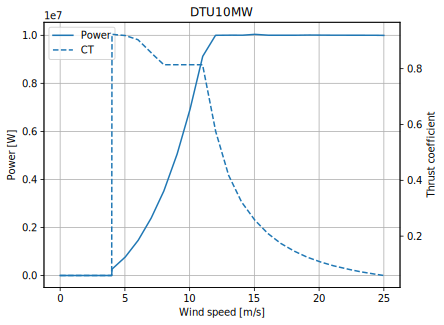

In [90]:
wind_turbines = DTU10MW()
n_wt = 20
wind_turbines.plot_power_ct();

Define the wind resource:

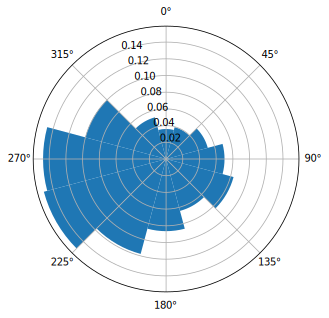

In [91]:
site = Hornsrev1Site()
site.plot_wd_distribution();

Define the area:

In [92]:
d_west_east = 4000  # [m] width
d_south_north = 2000  # [m] height
min_wt_spacing = 3.5*wind_turbines.diameter()  # [m] inter-turbine minimum distance
boundary = np.array([
    (0, 0),
    (d_west_east, 0),
    (d_west_east, d_south_north),
    (0, d_south_north)
])

Define the substation position:

In [93]:
x_ss, y_ss = (d_west_east/5, d_south_north/2)

Define the maximum step for the random search:

In [94]:
max_step = 100  # [m]

## Initial positions

In [95]:
# Generate initial random layout
x_init, y_init = poisson_disc_filler(
    n_wt,
    min_dist=min_wt_spacing,
    BorderC=boundary,
    seed=42,
    rounds=10,
).T

## Build components

### AEP component

In [96]:
# number of wind directions to consider
n_wd = 12

aep_comp = PyWakeAEPCostModelComponent(
    windFarmModel=Nygaard_2022(
        site=site,
        windTurbines=wind_turbines,
    ),
    n_wt=n_wt,
    wd=np.linspace(0.0, 360.0, n_wd, endpoint=False),
    objective=False,
)

### Electrical network component

#### Choose the router

Pick one of the available routers in OptiWindNet:

**EWRouter**

```python
from optiwindnet.api import EWRouter
router = EWRouter()
```

**HGSRouter**

```python
from optiwindnet.api import HGSRouter
router = HGSRouter(time_limit=0.1)  # seconds
```

**MILPRouter**

```python
from optiwindnet.api import MILPRouter
router = MILPRouter(
    solver_name='gurobi',  # or 'cplex', 'ortools'
    time_limit=1,          # seconds
    mip_gap=0.005,         # relative optimality gap (0.5%)
    verbose=True
)
```

> After choosing, pass `router` to `WindFarmNetwork(..., router=router)` through `WFNComponent`. If you use `MILPRouter`, make sure a supported solver is installed (and licensed if necessary).

Let's proceed with `HGSRouter`for this example. You can easily switch to other routers using the abovementioned codes.

In [97]:
from optiwindnet.api import HGSRouter
router = HGSRouter(time_limit=0.1)

Collect initial positions in OptiWindNet input format

In [98]:
turbines_pos = np.column_stack((x_init, y_init))
substations_pos = np.column_stack((x_ss, y_ss))

Define cables.

In [99]:
cables = np.array([(2, 2000), (5, 2200)])

Build a Cost model for electrical network (cabling) optimizaiton

In [100]:
class WFNComponent(CostModelComponent):
    def __init__(self, turbines_pos, substations_pos, cables, router, borderC=boundary, **kwargs):
        self.wfn = WindFarmNetwork(
            turbinesC=turbines_pos,
            substationsC=substations_pos,
            cables=cables,
            router=router,)
            #borderC=boundary)

        def compute(x, y, xs, ys):
            self.wfn.optimize(turbinesC=np.column_stack((x, y)),
                              substationsC=np.column_stack((xs, ys)),
                              )
            return self.wfn.cost(), {
                'network_length': self.wfn.length(),
                'terse_links': self.wfn.terse_links(),
            }

        def compute_partials(x, y, xs, ys):
            grad_wt, grad_ss = self.wfn.gradient(
                turbinesC=np.column_stack((x, y)),
                substationsC=np.column_stack((xs, ys)),
            )
            dc_dx, dc_dy = grad_wt[:, 0], grad_wt[:, 1]
            dc_dxss, dc_dyss = grad_ss[:, 0], grad_ss[:, 1]
            return [dc_dx, dc_dy, dc_dxss, dc_dyss]

        x_init, y_init = turbines_pos.T
        x_ss_init, y_ss_init = substations_pos.T
        super().__init__(
            input_keys=[('x', x_init), ('y', y_init),
                        ('xs', x_ss_init), ('ys', y_ss_init)],
            n_wt=turbines_pos.shape[0],
            cost_function=compute,
            cost_gradient_function=compute_partials,
            objective=False,
            output_keys=[('cabling_cost', 0.0)],
            additional_output=[
                ('network_length', 0.0),
                ('terse_links', np.zeros(turbines_pos.shape[0])),
            ],
            **kwargs,
        )

Initialize the `WFNComponent` with input data.

In [101]:
network_cost_comp = WFNComponent(
    turbines_pos=turbines_pos,
    substations_pos=substations_pos,
    cables=cables,
    router=router,
)

### NPV model

In [102]:
fixed_economic_parameters = dict(
    rated_rpm_array=np.full((n_wt,), 12.0),
    D_rotor_array=np.full((n_wt,), wind_turbines.diameter()),
    Power_rated_array=np.full((n_wt,), wind_turbines.power(20.0)*1e-6),
    hub_height_array=np.full((n_wt,), wind_turbines.hub_height()),
    water_depth_array=np.full((n_wt,), 33.0),
)

In [103]:
eco_eval = economic_evaluation(
    distance_from_shore=30,  # [km]
    energy_price=0.06,        # [€/kWh] revenue
    project_duration=25,     # [years]
)

In [104]:
# Internal Rate of Return
def calc_irr(AEP, cabling_cost, **kwargs):
    return eco_eval.calculate_irr(
        **fixed_economic_parameters,
        aep_array=np.full((n_wt,), AEP/n_wt*10**6),
        cabling_cost=cabling_cost,
    )

In [105]:
# Economy
npv_comp = CostModelComponent(
    input_keys=[
        ('AEP', 0),
        ('cabling_cost', 0)
    ],
    n_wt=n_wt,
    # cost_function=calc_npv,
    cost_function=calc_irr,
    objective=True,
    maximize=True,
    # output_keys=[('NPV', 0)],
    output_keys=[('IRR', 0)],
)

## Build Topfarm problem

In [106]:
cost_comp = TopFarmGroup([
    aep_comp,
    network_cost_comp,
    npv_comp,
])

In [107]:
tf_problem = TopFarmProblem(
    design_vars=dict(
        x=x_init,
        y=y_init,
    ),
    cost_comp=cost_comp,
    constraints=DistanceConstraintAggregation(
        XYBoundaryConstraint(boundary, 'polygon'),
        n_wt,
        min_wt_spacing,
        wind_turbines,
    ),
    driver=EasySGDDriver(maxiter=200),
    plot_comp=XYPlotComp(),
)

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000494 sec).
INFO: checking system...
INFO:     system check complete (0.000058 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000264 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000062 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000005 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000211 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000062 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000004 sec).


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000278 sec).
INFO: checking system...
INFO:     system check complete (0.000044 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000244 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000060 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000334 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000102 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000006 sec).


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


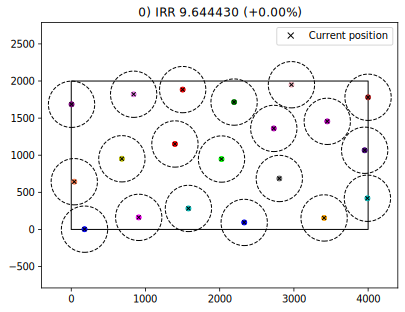

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Optimized in	78.877s


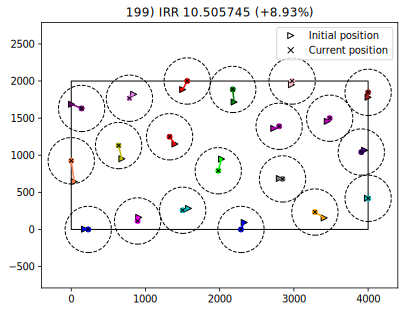

In [108]:
cost, state, recorder = tf_problem.optimize(disp=True)

## Plotting
In this section we monitor AEP, cabling_cost, IRR, and constraint_violation over time.

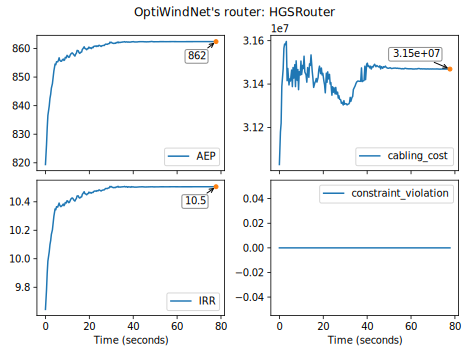

In [109]:
records_to_plot = ['AEP', 'cabling_cost', 'IRR', 'constraint_violation']
time = recorder['timestamp'] - recorder['timestamp'][0]
fig, axs = plt.subplots(math.ceil(len(records_to_plot)/2), 2, sharex=True, layout='constrained')


pos_final_values = [
    dict(offset=(-10, -10), ha='right', va='top'),
    dict(offset=(-10,  10), ha='right', va='bottom'),
    dict(offset=(-10, -10), ha='right', va='top'),
    None
]

for i, (ax, key) in enumerate(zip(axs.ravel(), records_to_plot)):
    line, = ax.plot(time, recorder[key], label=key)
    ax.legend()

    pos = pos_final_values[i] if i < len(pos_final_values) else None
    if pos is None:
        break

    # last point
    x_last = line.get_xdata()[-1]
    y_last = line.get_ydata()[-1]
    ax.plot(x_last, y_last, 'o', ms=4)

    ax.annotate(
        f"{y_last:.3g}",
        xy=(x_last, y_last),
        xytext=pos['offset'], textcoords='offset points',
        ha=pos['ha'], va=pos['va'],
        arrowprops=dict(arrowstyle='->', lw=1),
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='0.5', alpha=0.9),
    )


# label bottom subplots
for ax in axs[-1, :]:
    ax.set_xlabel("Time (seconds)")

router_name = type(router).__name__ 
sub_title = fig.suptitle(f"OptiWindNet's router: {router_name}")

Plot the optimized network for final wind farm layout.

<Axes: >

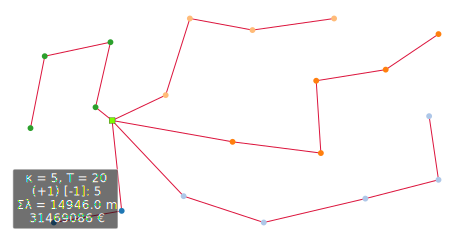

In [110]:
network_cost_comp.wfn.plot()